In [280]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

import networkx as nx
import pylab

In [281]:
def read_csv(path):
  df = pd.read_csv(path)
  tam = len(df.columns[1:])
  index = list(range(tam))
  positions = dict(zip(df.columns[1:].values, index))
  distances = df.to_numpy()
  distances = np.delete(distances,0,1)
  names = df.columns[1:].values
  return names, positions, distances

In [282]:
def create_graph(limit, nodes):
  coordinates = np.zeros([nodes,2])
  names = np.empty(nodes, dtype=np.chararray)
  distances = np.zeros([nodes,nodes])
  
  for i in range(nodes):
    coordinates[i] = [np.random.randint(limit),np.random.randint(limit)]
    names[i] = chr(65+i)

  for i in range(nodes):
    for j in range(nodes):
      distances[i,j] = np.linalg.norm(coordinates[i]-coordinates[j])
  
  #print(coordinates)
  #print(distances)

  dictionary = dict(zip(names, range(0,len(names))))
  # print(dictionary)
  dict_coordinates = dict(zip(names, coordinates))
  plot_solution(names,dict_coordinates)

  return names, coordinates, dict_coordinates, dictionary, distances

In [283]:
def plot_solution(individual, dict_coordinates):
  fig, ax = plt.subplots(figsize=(12,8))
  coordinates = np.zeros([len(individual),2])
  for i in range(len(individual)):
    coordinates[i] = [dict_coordinates[individual[i]][0],dict_coordinates[individual[i]][1]]
  plt.plot(coordinates[:,0], coordinates[:,1], marker="o", markersize=6, markeredgecolor="black", markerfacecolor="white")
  for i in range(len(individual)):
    print(individual[i],"->",end=" ")
    plt.annotate(individual[i], (dict_coordinates[individual[i]][0], dict_coordinates[individual[i]][1]), textcoords="offset points", xytext=(0,5), ha='center') #https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
  plt.show()

In [284]:
def plot_graph(adjacency_list, dictionary, matrix_distance):
  #https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python
  G = nx.DiGraph()
  for i in range(1, len(adjacency_list)):
    x = dictionary[adjacency_list[i-1]]
    y = dictionary[adjacency_list[i]]
    cost = matrix_distance[x][y]
    G.add_edges_from([(adjacency_list[i-1], adjacency_list[i])], weight=round(cost))
  pos=nx.spring_layout(G)
  edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
  #nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels) #graficar peso aristas
  nx.draw_networkx_labels(G, pos)
  nx.draw(G,pos,node_size=500,edge_color='r',arrows = False)
  pylab.show()

In [285]:
def f(positions, distances, individual): #Función objetivo
  cost = 0
  for i in range(1,len(individual)):
    x = positions[individual[i-1]]
    y = positions[individual[i]]
    cost += distances[x][y]
  return cost

In [286]:
def get_population(n, names):
  names = np.append(names,names[0])
  m = len(names)
  population = np.zeros([n,m], dtype = np.chararray ) #dtype='S'
  population = np.full_like(population, names)

  for i in range(n): 
    for j in range(m):
      limit = m-1 
      x=0
      y=0
      while (x==y):
        x = np.random.randint(1,limit)
        y = np.random.randint(1,limit) 
      population[i][x], population[i][y] = population[i][y], population[i][x]
  return population

## Selection

In [287]:
def roulette_selection(fitness):
  range_probability = np.zeros((len(fitness), 2))
  range_probability[0][0]=0
  total = np.sum(fitness)

  new_total = 0
  aux = fitness.copy()
  for i in range(len(aux)):
    aux[i] = total - fitness[i]
    new_total += aux[i]

  for i in range(len(aux)):
    PN = (aux[i])/new_total
    if i>0:
      range_probability[i][0] = range_probability[i-1][1]
      range_probability[i][1] = range_probability[i-1][1]+PN
    else:
      range_probability[i][0] = 0
      range_probability[i][1] = PN
  p = np.random.random() 
  #print(range_probability)
  for i in range(len(range_probability)):
    if p >=range_probability[i][0] and p<range_probability[i][1]:
      return i


In [288]:
def tournament_selection(fitness, k = 2):
  parents = random.sample(range(0, len(fitness)), k)
  winner = np.argmin(fitness[parents])
  return(parents[winner])

##Mutation

In [289]:
def swap_mutation(individual, Pm): 
  m = len(individual)
  limit = m-1 
  x = np.random.randint(1,limit)
  y = np.random.randint(1,limit)
  individual[x], individual[y] = individual[y], individual[x]
  return individual

In [290]:
def mutate(Population, Pm): 
  for i in range(len(Population)):
    p = np.random.random() #Return random floats in the half-open interval [0.0, 1.0).    
    if p < Pm:
      Population[i] = swap_mutation(Population[i],Pm)
  return Population

## Crossover

In [291]:
def simple_permutation_crossover(parentA, parentB):
  offspring = np.zeros(parentA.shape, dtype = np.chararray)
  offspring[:int(len(parentA)/2)] = parentA[:int(len(parentA)/2)]
  offspring[int(len(parentA)/2):] = parentB[int(len(parentA)/2):]
  #print("Antes", offspring)
  nodes = set(np.unique(parentA))
  left = set(np.unique(parentA)) - set(np.unique(offspring)) 
  #print(left)
  for i in range(1,len(offspring)):
    if not (offspring[i] in nodes):
      value = random.sample(left, 1)[0]
      left.remove(value)
      offspring[i] = value
    else:
      nodes.remove(offspring[i])
  #print("Despues", offspring,"\n")
  return offspring

In [292]:
def crossover(population,fitness,pop_size, Pr):
  offspring = np.zeros(population.shape,  dtype = np.chararray)
  for i in range(len(offspring)):
    p = np.random.random() #Return random floats in the half-open interval [0.0, 1.0).    
    if p < Pr:
      parentA = roulette_selection(fitness)
      parentB = roulette_selection(fitness)
      offspring[i] = simple_permutation_crossover(population[parentA], population[parentB])
    else:
      parent = roulette_selection(fitness)
      offspring[i] = population[parent]
  return offspring

## Algorithm

In [293]:
def genetic_algorithm(pop_size = 30, G = 100, Pr = 0.8, Pm = 0.3):
  names, coordinates, dict_coordinates, dictionary, distances = create_graph(100,10)
  population = get_population(pop_size, names)
  fitness = np.zeros(pop_size)
  elite = np.zeros(2)
  g = 0

  for i, individual in enumerate(population):
    fitness[i] = f(dictionary, distances, individual)

  elite = [min(fitness), population[np.argmin(fitness)]]
  #print(tournament_selection(fitness))
  #print(offspring, population, fitness)
  #print(elite)
  parents = np.zeros(pop_size)
  plot = (G*10)/100

  while g < G:
    population = crossover(population,fitness,pop_size, Pr)
    population = mutate(population,Pm)
    
    for i, individual in enumerate(population):
      fitness[i] = f(dictionary, distances, individual)
   
    actual_elite = [min(fitness), population[np.argmin(fitness)]]
    
    if actual_elite[0] < elite[0]:
      elite = actual_elite
    else:
      population[np.argmin(fitness)] = elite[1]

    if g%plot == 0:
      print(actual_elite[1], " - ", actual_elite[0])
      plot_graph(actual_elite[1], dictionary, distances)
    
    g += 1
  print("BEST SOLUTION:")
  print(elite[1], " - ", elite[0])
  plot_graph(elite[1], dictionary, distances)
  plot_solution(elite[1],dict_coordinates)


A -> B -> C -> D -> E -> F -> G -> H -> I -> J -> 

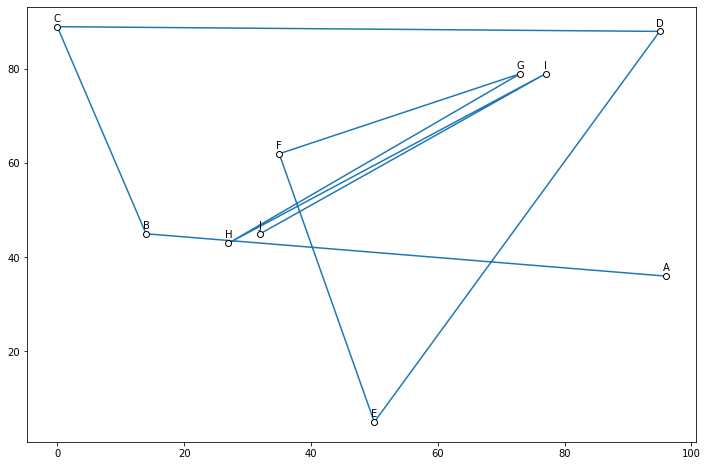

['A' 'E' 'B' 'D' 'I' 'F' 'J' 'H' 'C' 'G' 'A']  -  464.8587883221934


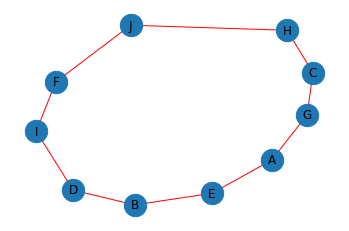

['A' 'E' 'F' 'J' 'B' 'C' 'H' 'I' 'G' 'D' 'A']  -  390.57719488986163


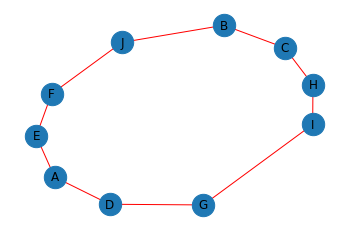

['A' 'E' 'B' 'F' 'C' 'H' 'J' 'I' 'G' 'D' 'A']  -  375.41119753666277


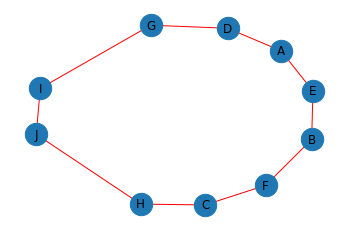

['A' 'E' 'B' 'F' 'C' 'H' 'J' 'I' 'G' 'D' 'A']  -  375.41119753666277


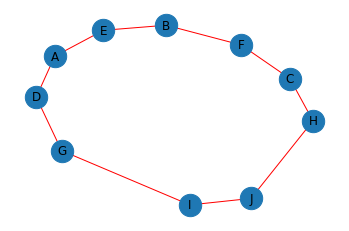

['A' 'E' 'B' 'C' 'F' 'H' 'J' 'G' 'I' 'D' 'A']  -  375.9423136421683


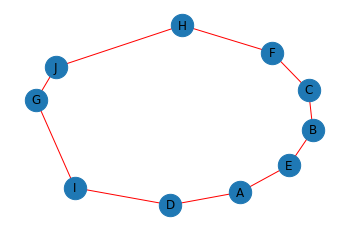

['A' 'E' 'B' 'C' 'J' 'H' 'F' 'G' 'I' 'D' 'A']  -  446.58411588945387


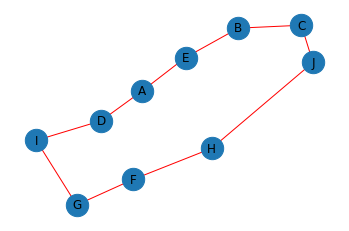

['A' 'E' 'B' 'C' 'J' 'H' 'F' 'G' 'I' 'D' 'A']  -  353.62891256063364


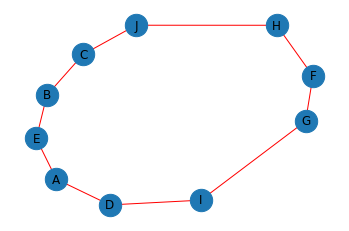

['A' 'E' 'B' 'C' 'H' 'J' 'F' 'G' 'I' 'D' 'A']  -  438.30643809481205


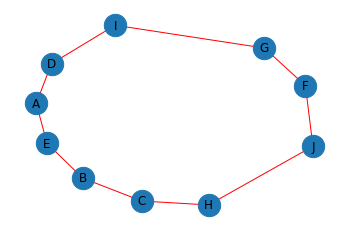

['A' 'E' 'B' 'C' 'H' 'J' 'F' 'G' 'I' 'D' 'A']  -  349.20872031161394


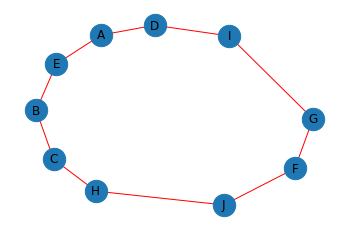

['A' 'E' 'B' 'C' 'H' 'J' 'F' 'G' 'I' 'D' 'A']  -  446.86105388907066


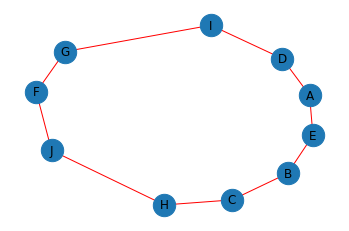

BEST SOLUTION:
['A' 'E' 'B' 'C' 'H' 'J' 'F' 'G' 'I' 'D' 'A']  -  349.20872031161394


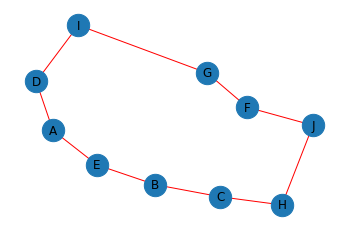

A -> E -> B -> C -> H -> J -> F -> G -> I -> D -> A -> 

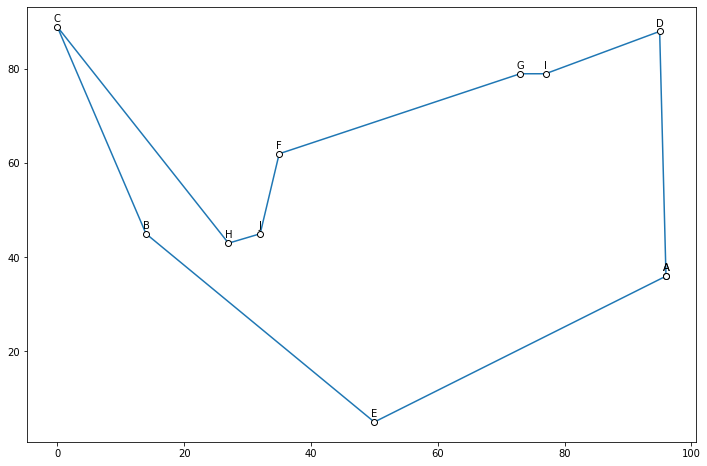

In [294]:
pop_size = 30       #Population size
G = 100             #Number of generations
Pr = 0.8            #Reproduction probability
Pm = 0.3            #Mutation probability

genetic_algorithm(pop_size, G, Pr, Pm)